In [3]:
from timeit import default_timer as timer
start = timer()

In [4]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.datasets import cifar10 as cf10

import matplotlib.pylab as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2023-10-10 20:36:44.377607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 20:36:46.339880: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nilray/miniconda3/envs/tf-gpu/lib/
2023-10-10 20:36:46.342905: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nilray/miniconda3/envs/tf-gpu/lib/
2023-10-10 20:36:46.342925: W tensorflow/compi

In [5]:
print("Tensorflow version: ",tf.__version__)

Tensorflow version:  2.11.1


In [6]:
# Load image data from CIFAR-10 dataset
(train_images,train_labels),(test_images,test_labels) = cf10.load_data()

In [7]:
# Define helper function to view images
def show_images(train_images,class_names,train_labels,nb_samples=12, nb_row=4):
    plt.figure(figsize=(12,12))
    for i in range(nb_samples):
        plt.subplot(nb_row,nb_row,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_images[i],cmap=plt.cm.binary)
        plt.xlabel(class_names[train_labels[i][0]])
    plt.show()
    

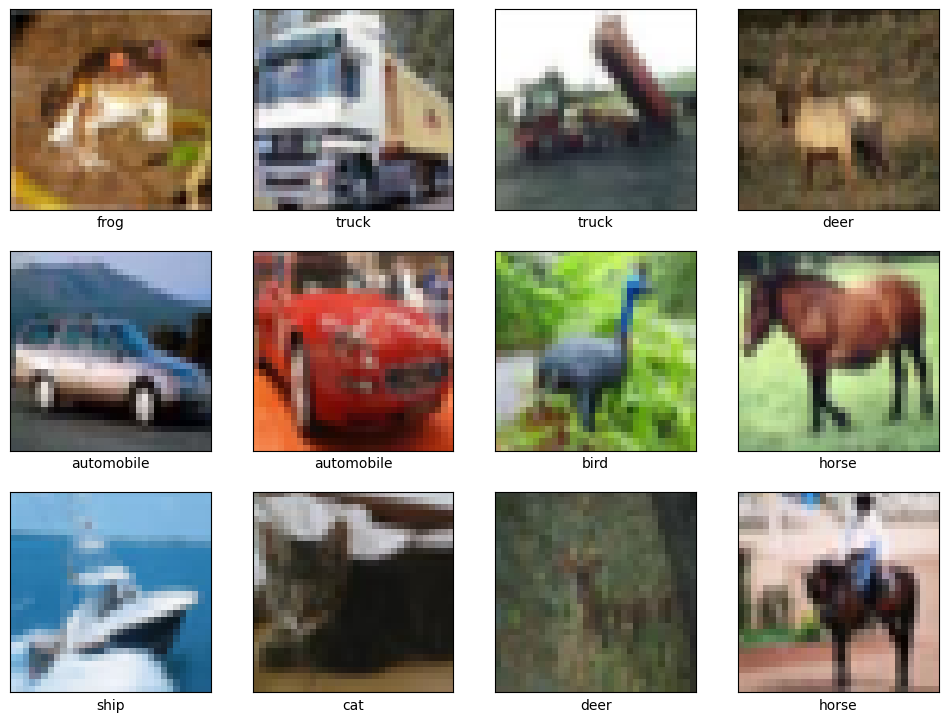

In [8]:
#Show samples images
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog','frog','horse','ship','truck']
show_images(train_images, class_names,train_labels)

In [9]:
# Data pre-processing
# normalize pixel values between 0 and 1
max_pixel_value = 255

train_images = train_images / max_pixel_value
test_images = test_images / max_pixel_value

In [10]:
# convert labels from text to one-hot vectors
train_labels = tf.keras.utils.to_categorical(train_labels, len(class_names))
test_labels = tf.keras.utils.to_categorical(test_labels, len(class_names))

In [41]:
# Define the model architecture

#Constants
INPUT_SHAPE = (32,32,3)
FILTER1_SIZE = 32
FILTER2_SIZE = 64
FILTER_SHAPE = (3,3)
POOL_SHAPE = (2,2)
FULLY_CONNECT_NUM = 128
NUM_CLASSES = len(class_names)

model = tf.keras.models.Sequential()
model.add(tfl.Conv2D(FILTER1_SIZE,FILTER_SHAPE,activation='relu',input_shape=INPUT_SHAPE))
model.add(tfl.MaxPooling2D(POOL_SHAPE))
model.add(tfl.Conv2D(FILTER2_SIZE,FILTER_SHAPE,activation='relu'))
model.add(tfl.MaxPooling2D(POOL_SHAPE))
model.add(tfl.Conv2D(FILTER2_SIZE*2,FILTER_SHAPE,activation='relu'))
model.add(tfl.MaxPooling2D(POOL_SHAPE))
model.add(tfl.Flatten())
model.add(tfl.Dense(FULLY_CONNECT_NUM,activation='relu'))
model.add(tfl.Dropout(rate=0.2))
model.add(tfl.Dense(NUM_CLASSES,activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 2, 2, 128)       

In [42]:
#Model compiling

BATCH_SIZE = 64
EPOCHS = 30
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
           ]

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=METRICS)


In [43]:
# model training

training_history = model.fit(x=train_images,
                             y=train_labels,
                             epochs=EPOCHS,
                             batch_size=BATCH_SIZE,
                             validation_data=(test_images, test_labels))


: 

In [32]:
# model evaluation helper function

def show_performance_curve(training_result, metric, metric_label):
    train_perf = training_result.history[str(metric)]
    validation_perf = training_result.history['val_'+str(metric)]
    #intersection_idx = np.argwhere(np.isclose(train_perf,validation_perf,atol=1e-2)).flatten()[0]
    #intersection_value = train_perf[intersection_idx]
    
    plt.plot(train_perf, label=metric_label)
    plt.plot(validation_perf,label='val_'+str(metric))
    
    #plt.axvline(x=intersection_idx, color='r', linestyle='--', label='Intersection')
    
    # plt.annotate(f'Optimal value: {intersection_value:.4f}',
    #              xy=(intersection_idx,intersection_value),
    #              xycoords='data',
    #              fontsize=10,
    #              color = 'green')
    plt.xlabel('Epoch')
    plt.ylabel(metric_label)
    plt.legend(loc='lower right')

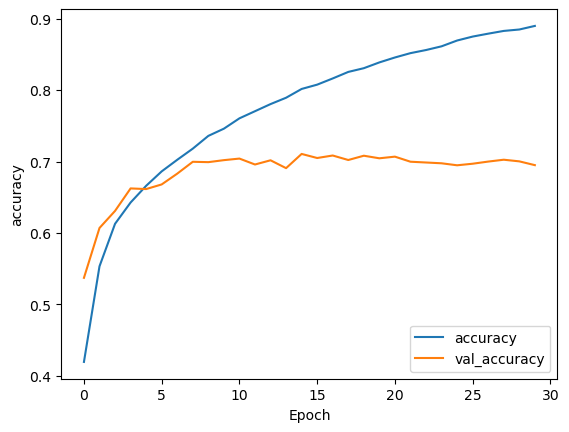

In [33]:
# Plot performance for "Accuracy" 
show_performance_curve(training_history,'accuracy','accuracy')

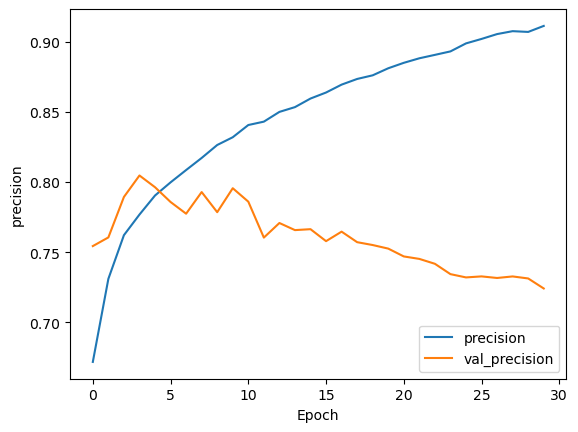

In [34]:
# Plot performance for "Precision" 
show_performance_curve(training_history,'precision','precision')

313/313 [==============================] - 1s 2ms/step


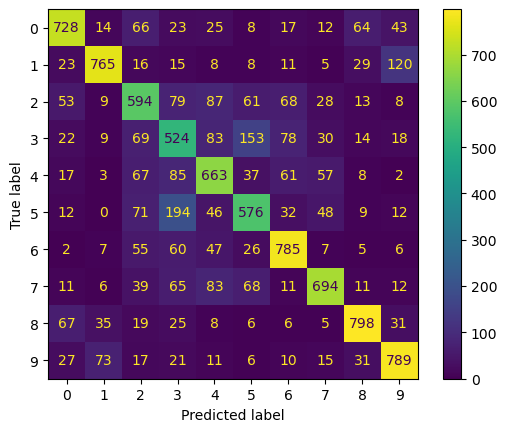

In [28]:
#Confusion matrix

test_predictions = model.predict(test_images)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_true_labels = np.argmax(test_labels,axis=1)

cm = confusion_matrix(test_true_labels, test_predicted_labels)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)

cmd.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.show()

In [ ]:
end = timer()
print("--- %s seconds ---" % (end-start))